In [1]:
import numpy as np
from numba import jit
import time
from scipy.interpolate import interp1d

G=1
c=1
M01 = 1.474 * 10**3

G1 = 6.67*10**(-11)             ############ N m^2/ kg^2
c1 = 3*10**(8)                  ############ m / s

Mev_fm3_to_GU = 1.6* 10**32 * G1/c1**4


from numba import jit
@jit(nopython = True)
def love_number(C,y):
  k2 = 8 / 5 * C ** 5 * (1 - 2 * C) **(2) * (2 + 2 * C * (y - 1) - y) * (2 * C * (6 - 3 * y + 3 * C * (5 * y - 8)) + 4 * C ** 3 * (13 - 11 * y + C * (3 * y - 2) + 2 * C ** 2 * (1 + y)) + 3 * (1 - 2 * C) ** 2 * (2 - y + 2 * C * (y - 1)) * (np.log(1 - 2 * C))) ** (-1)
  return k2


@jit(nopython = True)
def beta_and_H(r, p, H, m, beta, parr, earr):
    dp = p * 0.005

    el_3 = en_dens(parr, earr, p - 3 * dp)
    el_2 = en_dens(parr, earr, p - 2 * dp)
    el_1 = en_dens(parr, earr, p - 1 * dp)
    er_3 = en_dens(parr, earr, p + 3 * dp)
    er_2 = en_dens(parr, earr, p + 2 * dp)
    er_1 = en_dens(parr, earr, p + 1 * dp)

    de_dp = (-1 / 60 * el_3 + 3 / 20 * el_2 - 3 / 4 * el_1 + 3 / 4 * er_1 - 3 / 20 * er_2 + 1 / 60 * er_3) / dp

    #G = 6.67430e-11  # Gravitational constant
    #c = 299792458.0  # Speed of light
    G = 1
    c = 1

    e = en_dens(parr, earr, p)
    dbeta_dr = 2 * (1 - 2 * m / r ) ** (-1) *H * (-2 * np.pi * G / c ** 2 * (5 * e + 9 * p / c ** 2 + de_dp * c ** 2 * (e + p / c ** 2)) + 3 / r ** 2 + 2 * (1 - 2 * m / r ) ** (-1) * ( m / r ** 2 + G / c ** 4 * 4 * np.pi * r * p) ** 2) + 2 * (1 - 2 * m / r ) ** (-1) *beta / r * (-1 + m / r + 2 * np.pi * r ** 2 * G / c ** 2 * (e - p / c ** 2))

    dHdr = beta
    return dbeta_dr, dHdr

@jit(nopython=True)
def en_dens(parr, earr, p):
  if p < min(parr) or p > max(parr):
    e = 0
  else:
    e = ene_interp(parr, earr, p)
  return e

@jit(nopython = True)
def find_ind(arr, val):
    for i, item in enumerate(arr):
        if val > item:
            continue
        else:
            return i
    return len(arr)

class PressureOutOfRangeError(Exception):
    pass

@jit(nopython = True)
def en_dens(parr, earr, p):
  if p < min(parr) or p > max(parr):
    e = 0
  else:
    e = ene_interp(parr, earr, p)
  return e


@jit(nopython = True)
def ene_interp(pre_arr, ene_arr, pressure):
    if pressure < min(pre_arr) or pressure > max(pre_arr):
        raise PressureOutOfRangeError("Pressure is out of range.")
    else:
        ind = find_ind(pre_arr, pressure)
        left_p = pre_arr[ind - 1]
        right_p = pre_arr[ind]
        left_e = ene_arr[ind-1]
        right_e = ene_arr[ind]
        ene_val = (pressure - left_p)*(right_e - left_e)/(right_p - left_p) + left_e
    return ene_val

@jit(nopython = True)
def pre_interp(pre_arr, ene_arr, energy):
    if energy < min(ene_arr) or energy > max(ene_arr):
        raise PressureOutOfRangeError("Energy is out of range.")
    else:
        ind = find_ind(ene_arr, energy)
        left_p = pre_arr[ind - 1]
        right_p = pre_arr[ind]
        left_e = ene_arr[ind-1]
        right_e = ene_arr[ind]
        pre_val = (energy - left_e)*(right_p - left_p)/(right_e - left_e) + left_p
    return pre_val

def cs2_interp(cs2_arr, pre_arr, pressure):
    if pressure < min(pre_arr) or pressure > max(pre_arr):
        raise PressureOutOfRangeError("Pressure is out of range.")
    else:
        ind = find_ind(pre_arr, pressure)
        left_c = cs2_arr[ind - 1]
        right_c = cs2_arr[ind]
        left_p = pre_arr[ind-1]
        right_p = pre_arr[ind]
        cs2_val = (pressure - left_p)*(right_c - left_c)/(right_p - left_p) + left_c
    return cs2_val

@jit(nopython = True)
def Tov_eqn(P, r, m, dens, press, G, c, min_pressure):
    if P < min_pressure:
        return 0.0
    else:
        eden = ene_interp(press, dens, P)
        return -(G * ((P / c ** 2) + eden) * (m + 4 * np.pi * r ** 3 * P / c ** 2)) / (r * (r - 2 * G * m / c ** 2))

@jit(nopython = True)
def mass_eqn(r, ene):
    return 4 * np.pi * r ** 2 * ene


def TOV_module(cen_dens, pressure, density, exit_Pre,love=False, to_print=False):
    asi = 0
    P_exit =exit_Pre
    for i in range(len(cen_dens)):
        press = np.array(pressure)
        dens = np.array(density)
        d = cen_dens[i]
        P0 = pre_interp(press, dens, d)
        r = 10
        P = P0
        m = mass_eqn(r,d)
        h = 1
        a0 = 1
        H0 = a0*r**2
        beta0 = 2*a0*r
        min_pressure = min(press)
        beta = beta0
        H = H0
        if  love == True:
            #print("Entering Love loop")
            while P > P_exit :
                k1_m = mass_eqn(r, ene_interp(press, dens, P))
                k2_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k3_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k4_m = mass_eqn(r + h, ene_interp(press, dens, P))

                k1_p = Tov_eqn(P, r, m, dens, press, G, c, min_pressure)
                k2_p = Tov_eqn(P + k1_p * h / 2, r + h / 2, m + k1_m * h / 2, dens, press, G, c, min_pressure)
                k3_p = Tov_eqn(P + k2_p * h / 2, r + h / 2, m + k2_m * h / 2, dens, press, G, c, min_pressure)
                k4_p = Tov_eqn(P + k3_p * h, r + h, m + k3_m * h, dens, press, G, c, min_pressure)

                k1_dbeta_dr, k1_dHdr = beta_and_H(r, P, H, m, beta, press, dens)
                k2_dbeta_dr, k2_dHdr = beta_and_H(r + 0.5 * h, P + 0.5 * h * k1_p, H + 0.5 * h * k1_dHdr, m + 0.5*h*k1_m, beta + 0.5*h*k1_dbeta_dr, press, dens)
                k3_dbeta_dr, k3_dHdr = beta_and_H(r + 0.5 * h, P + 0.5 * h * k2_p, H + 0.5 * h * k2_dHdr, m + 0.5*h*k2_m, beta + 0.5*h*k2_dbeta_dr, press, dens)
                k4_dbeta_dr, k4_dHdr = beta_and_H(r + h, P + h * k3_p, H + h * k3_dHdr, m + h*k3_m, beta + h*k3_dbeta_dr, press, dens)

                beta = beta + (h / 6.0) * (k1_dbeta_dr + 2 * k2_dbeta_dr + 2 * k3_dbeta_dr + k4_dbeta_dr)
                H = H + (h / 6.0) * (k1_dHdr + 2 * k2_dHdr + 2 * k3_dHdr + k4_dHdr)
                P += h * (k1_p + 2 * k2_p + 2 * k3_p + k4_p) / 6
                m += h * (k1_m + 2 * k2_m + 2 * k3_m + k4_m) / 6
                r += h
            R.append(r/1000)
            M.append(m/M01)
            y = r * beta/ (H)
            C = m/(r)
            k2 = love_number(C,y)
            Com.append(C)
            Love.append(k2)
            if to_print == True:
                print("star ", i," done")
        else:
            #print("Entering No Love loop")
            while P > P_exit :
                k1_m = mass_eqn(r, ene_interp(press, dens, P))
                k2_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k3_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k4_m = mass_eqn(r + h, ene_interp(press, dens, P))

                k1_p = Tov_eqn(P, r, m, dens, press, G, c, min_pressure)
                k2_p = Tov_eqn(P + k1_p * h / 2, r + h / 2, m + k1_m * h / 2, dens, press, G, c, min_pressure)
                k3_p = Tov_eqn(P + k2_p * h / 2, r + h / 2, m + k2_m * h / 2, dens, press, G, c, min_pressure)
                k4_p = Tov_eqn(P + k3_p * h, r + h, m + k3_m * h, dens, press, G, c, min_pressure)

                P += h * (k1_p + 2 * k2_p + 2 * k3_p + k4_p) / 6
                m += h * (k1_m + 2 * k2_m + 2 * k3_m + k4_m) / 6
                r += h
            R.append(r/1000)
            M.append(m/M01)
            if to_print == True:
                print("star ", i," done")
    return R,M,Com,Love

In [2]:
import numpy as np
import matplotlib.pyplot as plt


data1 = np.loadtxt('eos_DD2BPS_hadronic_cs2.csv', delimiter=',',skiprows=1)

In [3]:
data1G1 = 6.67*10**(-11)             ############ N m^2/ kg^2
c1 = 3*10**(8)  

Mev_fm3_to_GU = 1.6* 10**32 * G1/c1**4

density_dat = data1[:, 2]
pressure_dat = data1[:, 3]

# sound_speed_dat = data1[:,2]

density_dat_GU = density_dat*Mev_fm3_to_GU
pressure_dat_GU = pressure_dat*Mev_fm3_to_GU

# density_dat_GU.astype(np.float64)
# pressure_dat_GU.astype(np.float64)

print(np.max(density_dat_GU), np.max(pressure_dat_GU))
print(np.min(density_dat_GU), np.min(pressure_dat_GU))

# print(density_dat_GU)



3.3839594469135796e-09 2.2416865382716047e-09
4.8682238419753086e-20 1.9990764049382715e-25


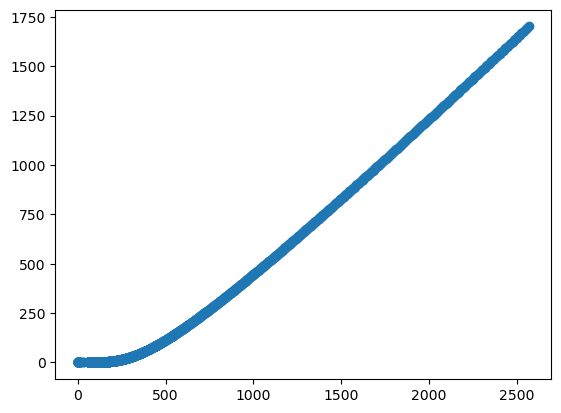

In [4]:
plt.plot(density_dat, pressure_dat, label='EOS')
plt.scatter(density_dat, pressure_dat, label='EOS')

In [5]:
central_energy = np.logspace(np.log10(np.max(density_dat_GU)*0.999),np.log10( 2.072392843084521e-10),50)
#central_energy = np.asarray(central_energy[1])
print(np.max(central_energy), np.min(central_energy),central_energy[4])

3.3805754874666724e-09 2.072392843084521e-10 2.691593876576457e-09


In [6]:
M= []
R = []
Com = []
Love = []

R,M,Com,Love = TOV_module(central_energy, pressure_dat_GU,density_dat_GU,exit_Pre=np.min(1.1*pressure_dat_GU),love=True,to_print=True)

star  0  done
star  1  done
star  2  done
star  3  done
star  4  done
star  5  done
star  6  done
star  7  done
star  8  done
star  9  done
star  10  done
star  11  done
star  12  done
star  13  done
star  14  done
star  15  done
star  16  done
star  17  done
star  18  done
star  19  done
star  20  done
star  21  done
star  22  done
star  23  done
star  24  done
star  25  done
star  26  done
star  27  done
star  28  done
star  29  done
star  30  done
star  31  done
star  32  done
star  33  done
star  34  done
star  35  done
star  36  done
star  37  done
star  38  done
star  39  done
star  40  done
star  41  done
star  42  done
star  43  done
star  44  done
star  45  done
star  46  done
star  47  done
star  48  done
star  49  done


Text(0, 0.5, 'M/Msun')

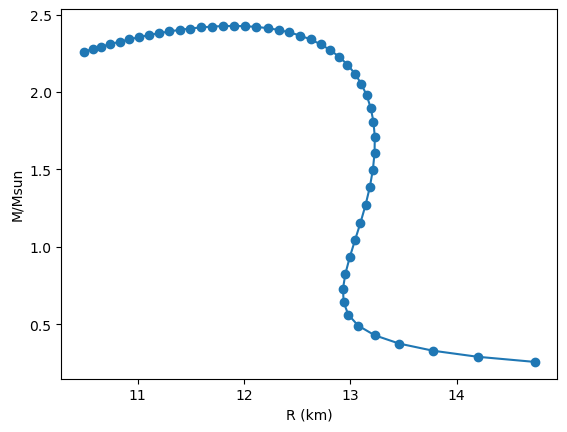

In [68]:
plt.plot(R,M, label='TOV')
plt.scatter(R,M, label='TOV')
plt.xlabel('R (km)')
plt.ylabel('M/Msun')

In [69]:
## Tidal Deformability Calculation

def Lambda(k2, C):
    return (2/3)*k2*C**(-5.0)



In [70]:

m1 = np.linspace(1.36,1.60,10)


# m2 = np.linspace(1.16,1.36,10)
#q = np.asarray([0.73,0.80,0.87,0.95])

q = np.linspace(0.73,1.00,10)

m2 = m1*q

for i in range(len(m2)):
    if m2[i] > 1.36:
        m2[i] = 1.36
    if m2[i] < 1.00:
        m2[i]= 1.00



print(m2)
print(m1)

radius_from_mass = interp1d(M,R,fill_value='extrapolate')

r1 = radius_from_mass(m1)
r2 = radius_from_mass(m2)

print(r2)

love_from_mass = interp1d(M,Love,fill_value='extrapolate')
Compactness_from_mass = interp1d(M,Com,fill_value='extrapolate')

love1 = love_from_mass(m1)
love2 = love_from_mass(m2)

C1 = Compactness_from_mass(m1)
C2 = Compactness_from_mass(m2)

print(love2)

print(C1, C2)

print('M_TOV = ',np.max(M))
print('R_1.6 = ', radius_from_mass(1.6))

[1.         1.05386667 1.11653333 1.1808     1.24666667 1.31413333
 1.36       1.36       1.36       1.36      ]
[1.36       1.38666667 1.41333333 1.44       1.46666667 1.49333333
 1.52       1.54666667 1.57333333 1.6       ]
[13.02542715 13.04966676 13.07842235 13.10682271 13.13428258 13.15936877
 13.17533224 13.17533224 13.17533224 13.17533224]
[0.11582233 0.11460055 0.1121844  0.10954792 0.10660588 0.10305146
 0.10044091 0.10044091 0.10044091 0.10044091]
[0.1521446  0.15502662 0.15792111 0.1608156  0.1637101  0.16660459
 0.16952191 0.17244367 0.17536543 0.17828719] [0.11315267 0.11903273 0.12582765 0.13278542 0.13990032 0.14718905
 0.1521446  0.1521446  0.1521446  0.1521446 ]
M_TOV =  2.4270743421656706
R_1.6 =  13.228034737373656


In [71]:
lam1 = Lambda(love1,C1)
lam2 = Lambda(love2,C2)

print(lam1)
print(lam2)

[821.36585032 736.45591515 660.42371675 593.07325442 533.30256714
 480.16412285 432.47312795 389.90620892 351.91564395 317.95691914]
[4162.71860605 3197.15373698 2371.15960752 1769.13488536 1326.16148834
  994.45547391  821.36585032  821.36585032  821.36585032  821.36585032]


## Dietric et.al 2017 ejecta Mass Equation

In [72]:
def dietrich_ejecta_equation(m1,m2):

    msun = 1.9885e33

    C1 = Compactness_from_mass(m1)
    C2 = Compactness_from_mass(m2)

    q = m2/m1

    m1_b = ((m1/msun)+(13/200)*(m1/msun)**2)*msun
    m2_b = ((m2/msun)+(13/200)*(m2/msun)**2)*msun

    Mej = (-1.36595*((m2/m1)**(1/3))*(1/C1 - 2) + 6.11252*(m2/m1)**(-2.5484)-49.43355*(1-m1/m1_b))*m1_b +  (-1.36595*((m1/m2)**1/3)*(1/C2 - 2) + 6.11252*(m1/m2)**(-2.5484)-49.43355*(1-m2/m2_b))*m2_b + 16.1144

    Mej = Mej*msun*1e-3

    return q,Mej

In [80]:

def coughlin_ejecta_equation(m1,m2,lambda1,lambda2,params):
    
    c = 2.99792458e10
    G = 6.67e-8  # Gravitational constant

    global Msun
    Msun = 1.9885e33  # Solar mass in grams

    b1 = params

    q = m2/m1

    C1 = Compactness_from_mass(m1)
    C2 = Compactness_from_mass(m2)

    # M_thr = G*(2.4270743421656706)*Msun/(c**2*(13.228034737373656)*1e5)

    # log_ej = (b1*m1*((1/(0.360-0.0355*np.log(lambda1)+0.000705*np.log(lambda1)**2)) - 1)+ 0.2116*m2*(m1/m2)**(-2.905)-2.42/2)+(b1*m2*((1/(0.360-0.0355*np.log(lambda2)+0.000705*np.log(lambda2)**2)) - 1)+ 0.2116*m1*(m2/m1)**(-2.905)-2.42/2)

    log_ej = (b1*m1*((1/C1) - 2)+ 0.2116*m2*(m1/m2)**(-2.905)-2.42/2)+(b1*m2*((1/C2) - 2)+ 0.2116*m1*(m2/m1)**(-2.905)-2.42/2)

    M_dyn = 10**(log_ej)*1.9885e33

    # log_M_disc = np.maximum(-3,-31.335*(1-0.976*np.arctan((1.0474-(m1+m2)/(2.4270743421656706))/0.05957)))
    # M_disc = 10**(log_M_disc)*1.9885e33

    Mej = M_dyn #+ M_disc 

    # if Mej < 1e-6:
    #     print(Mej)

    return q, Mej

    # print(f'The ejecta mass is: {Mej/Msun} Msun \n')
    # print(f'The parameter values are m1 = {m1} , m2 = {m2} , lambda1 = {lambda1} , lambda2 = {lambda2} and b1 = {params}\n')

    # if write:
    #     with open('ejecta_mass.txt', 'a') as f:
    #         f.write(f'{m1} {m2} {lambda1} {lambda2} {Mej/Msun} {params}\n')


In [81]:
q,Mej = coughlin_ejecta_equation(m1,m2,lam1,lam2,-0.0719)

q1,Mej1 = dietrich_ejecta_equation(m1,m2)

In [82]:
Mej,q

(array([5.36322654e+30, 5.02885079e+30, 4.71080365e+30, 4.51753476e+30,
        4.42564421e+30, 4.42323220e+30, 4.54892830e+30, 4.81402225e+30,
        5.12136370e+30, 5.47697373e+30]),
 array([0.73529412, 0.76      , 0.79      , 0.82      , 0.85      ,
        0.88      , 0.89473684, 0.87931034, 0.86440678, 0.85      ]))

In [83]:
Mej1

array([5.01203429e+31, 4.89945558e+31, 4.78254292e+31, 4.70679415e+31,
       4.66923280e+31, 4.66781905e+31, 4.72191637e+31, 4.83518357e+31,
       4.95833811e+31, 5.09133984e+31])

Text(0.5, 1.0, 'Ejecta_Comparison_DD2')

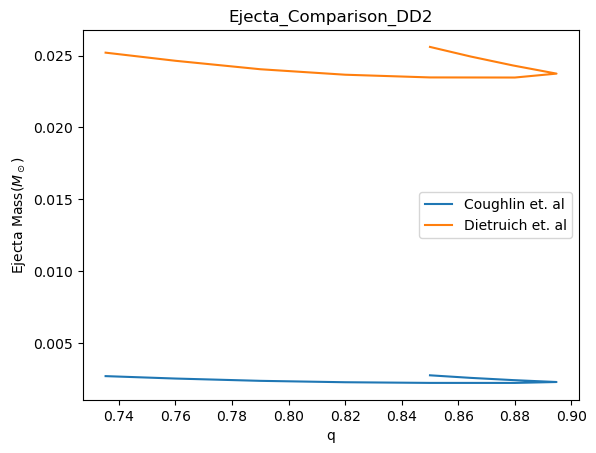

In [84]:
plt.plot(q,Mej/Msun,label = 'Coughlin et. al')
plt.plot(q1,Mej1/Msun,label = 'Dietruich et. al')
plt.legend()

plt.xlabel('q')
plt.ylabel(r'Ejecta Mass($M_\odot$)')

plt.title('Ejecta_Comparison_DD2')
# plt.savefig('Fig/Ejecta_Comparison_DD2.png')

In [78]:
Mej1/Msun

array([0.0252051 , 0.02463895, 0.02405101, 0.02367007, 0.02348118,
       0.02347407, 0.02374612, 0.02431573, 0.02493507, 0.02560392])